In [1]:
# Setup (Imports)

from LoadData import *

from keras.layers import Dense, BatchNormalization, Activation, Dropout, Merge
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.models import load_model, Sequential

import numpy as np
import os

import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
# Setup (Globals/Hyperz)

window_size_ticker     = 14
window_size_headlines  = 9
epochs       = 500
batch_size   = 64
emb_size     = 100

In [3]:
# Loading and Splitting Data

def get_data(stock):
    
    AllX, AllX2, AllY = create_timeframed_doc2vec_ticker_classification_data(stock, window_size_ticker, window_size_headlines, min_time_disparity=4)
    
    trainX, trainX2, trainY, testX, testX2, testY = split_data2(AllX, AllX2, AllY, ratio=.85)
    
    return (trainX, trainX2, trainY), (testX, testX2, testY)


In [4]:
# Make Model

def get_model():
    
    ## Load
    
    ticker_model = load_model(os.path.join('models', 'basic-classification.h5'))
    headline_model = load_model(os.path.join('models', 'headline-classification.h5'))
    
    ticker_model.pop()
    headline_model.pop()
    
    ## Merge
    
    combined = Sequential()
    
    combined.add(Merge([headline_model, ticker_model], mode='concat'))
    
    combined.add(Dense(16,          name="combined_d1"))
    combined.add(BatchNormalization(name="combined_bn1"))
    combined.add(Activation('relu', name="combined_a1"))
    combined.add(Dropout(0.3,       name="combined_do1"))

    # combined.add(Dense(1, activation='sigmoid', name="combined_d2"))
    combined.add(Dense(2, activation='softmax', name="combined_d2"))
    
    # combined.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    combined.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return combined


In [5]:
# Run (Load)

if __name__ == "__main__":

    (trainX, trainX2, trainY), (testX, testX2, testY) = get_data('AAPL')
    
    # trainY = trainY[:, 0] == 1
    # testY = testY[:, 0] == 1

    print(trainX.shape, trainX2.shape, trainY.shape)


(326, 9, 100) (326, 14, 5) (326,)


H:\Users\Shriv\Anaconda3\envs\tf-cpu\lib\site-packages\ipykernel\__main__.py:17: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.


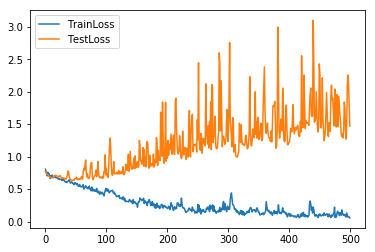

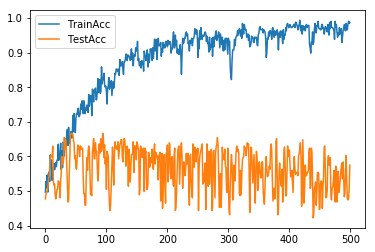

In [6]:
# Run (Train)

if __name__ == "__main__":

    model = get_model()
    
    checkpoint = ModelCheckpoint(os.path.join('..', 'models', 'headlineticker-classification.h5'), 
                                 monitor='val_acc', 
                                 verbose=0, 
                                 save_best_only=True)
    
    history = model.fit([trainX, trainX2], trainY, epochs=epochs, 
                                           batch_size=batch_size, 
                                           validation_data=([testX, testX2], testY),
                                           verbose=0, 
                                           callbacks=[checkpoint])

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.legend(['TrainLoss', 'TestLoss'])
    plt.show()

    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.legend(['TrainAcc', 'TestAcc'])
    plt.show()
